## Assignment
Your goal is to achieve a model with a consistent R2 and only statistically significant parameters across multiple samples.

We'll use the property crime model based on the FBI:UCR data. Since your model formulation to date has used the entire New York State 2013 dataset, you'll need to validate it using some of the other crime datasets available at the FBI:UCR website. Options include other states crime rates in 2013 or crime rates in New York State in other years or a combination of these.

Based on the results of your validation test, create a revised model, and then test both old and new models on a new holdout or set of folds.


Data Source: https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts

In [1]:
import math

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

%matplotlib inline
sns.set_style('white')

In [2]:
NY2013 = pd.read_excel('/Users/marenbeckman/Desktop/Data_Science/FBI/new_york_by_city_2013.xls')

In [3]:
NY2013.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,1861.0,0.0,0.0,NaN,0.0,0.0,0.0,12.0,2.0,10.0,0.0,0.0
1,Addison Town and Village,2577.0,3.0,0.0,NaN,0.0,0.0,3.0,24.0,3.0,20.0,1.0,0.0
2,Akron Village,2846.0,3.0,0.0,NaN,0.0,0.0,3.0,16.0,1.0,15.0,0.0,0.0
3,Albany,97956.0,791.0,8.0,NaN,30.0,227.0,526.0,4090.0,705.0,3243.0,142.0,NaN
4,Albion Village,6388.0,23.0,0.0,NaN,3.0,4.0,16.0,223.0,53.0,165.0,5.0,NaN


In [4]:
NY2013.columns

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3'],
      dtype='object')

In [5]:
#clean up target variable
NY2013.rename(columns={'Property\ncrime': 'Property_Crime'}, inplace=True)
NY2013 = NY2013[np.isfinite(NY2013['Property_Crime'])]

In [6]:
# Create New Features

NY2013['Population_Squared'] = NY2013['Population'] * NY2013['Population']

NY2013['Murder'] = 0
NY2013.loc[NY2013['Murder and\nnonnegligent\nmanslaughter'] > 0, 'Murder'] = 1

NY2013.rename(columns={'Robbery': 'Robberies'}, inplace=True)

NY2013['Robbery'] = 0
NY2013.loc[NY2013['Robberies'] > 0, 'Robbery'] = 1

NY2013['Population_Log'] = np.log(NY2013['Population'])

NY2013.rename(columns={'Larceny-\ntheft': 'LarcenyTheft'}, inplace=True)

NY2013['Larceny_Squared'] = NY2013['LarcenyTheft'] * NY2013['LarcenyTheft']

In [7]:
NY2013.columns

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robberies', 'Aggravated\nassault', 'Property_Crime', 'Burglary',
       'LarcenyTheft', 'Motor\nvehicle\ntheft', 'Arson3', 'Population_Squared',
       'Murder', 'Robbery', 'Population_Log', 'Larceny_Squared'],
      dtype='object')

In [8]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = NY2013['Property_Crime'].values.reshape(-1, 1)
X = NY2013[['Population','Population_Squared','Murder', 'Robbery','Population_Log', 'LarcenyTheft', 'Larceny_Squared', 'Burglary']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 1.06190047e-03 -1.03669799e-09 -7.07896574e-01  2.52359441e+00
  -5.61983423e+00  9.59456427e-01  5.24683538e-06  1.20813611e+00]]

Intercept: 
 [41.42143649]

R-squared:
0.9999981503228312


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [9]:
# Use train_test_split to create holdout groups for training and test groups
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit(X, Y).score(X, Y)))

With 20% Holdout: -4.082891855505544
Testing on Sample: 0.9999981503228312


In [10]:
#cross validation test
print('Cross Validation Score:', cross_val_score(regr, X, Y, cv=10))

Cross Validation Score: [ 0.99982943  0.99989161  0.99927154  0.99940919  0.99842846  0.99820367
 -3.3519333   0.99989521  0.999989    0.99923947]


There's clearly a problem with the model, so let's try the stats model to see what more we can learn.

In [11]:
#model formula
linear_formula = 'Property_Crime ~ Population+Population_Squared+Murder+Robbery+Population_Log+LarcenyTheft+Larceny_Squared+Burglary'

#fit model to data
lm = smf.ols(formula=linear_formula, data=NY2013).fit()

print('Coefficients:\n', lm.params)

Coefficients:
 Intercept             4.142144e+01
Population            1.061900e-03
Population_Squared   -1.036698e-09
Murder               -7.078966e-01
Robbery               2.523594e+00
Population_Log       -5.619834e+00
LarcenyTheft          9.594564e-01
Larceny_Squared       5.246835e-06
Burglary              1.208136e+00
dtype: float64


In [12]:
print('P-Values:\n', lm.pvalues)

P-Values:
 Intercept              5.041555e-08
Population             3.337863e-45
Population_Squared     1.492060e-18
Murder                 7.275825e-01
Robbery                8.974312e-02
Population_Log         4.365269e-09
LarcenyTheft           0.000000e+00
Larceny_Squared        2.556663e-18
Burglary              5.282981e-273
dtype: float64


In [28]:
NY2013['LarcenyTheft'].describe()

count       348.000000
mean        637.017241
std        6346.054451
min           0.000000
25%          31.000000
50%          94.000000
75%         287.250000
max      117931.000000
Name: LarcenyTheft, dtype: float64

It's looks like the presence of Murder and Robbery in a city isn't significant to Property Crime, so let's take those out.

In [21]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = NY2013['Property_Crime'].values.reshape(-1, 1)
X = NY2013[['Population','Population_Squared','Population_Log', 'LarcenyTheft', 'Larceny_Squared', 'Burglary']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 1.03875775e-03 -1.03234127e-09 -4.88760425e+00  9.60161461e-01
   5.23316081e-06  1.20749063e+00]]

Intercept: 
 [36.50201656]

R-squared:
0.9999981341228144


As expected, the R-squared value stays virtually the same.  So how does this new model look in holdout and cross validation tests

In [22]:
#holdout test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit(X, Y).score(X, Y)))

#cross validation test
print('\nCross Validation Score:', cross_val_score(regr, X, Y, cv=10))

With 20% Holdout: -3.8022348641498294
Testing on Sample: 0.9999981341228144

Cross Validation Score: [ 0.99982903  0.99988945  0.9992503   0.99940372  0.99850595  0.99829542
 -3.31944354  0.9998979   0.99998821  0.99922374]


We've still got some problems.  Let's try a heat map to see if we're missing any potentially impactful features

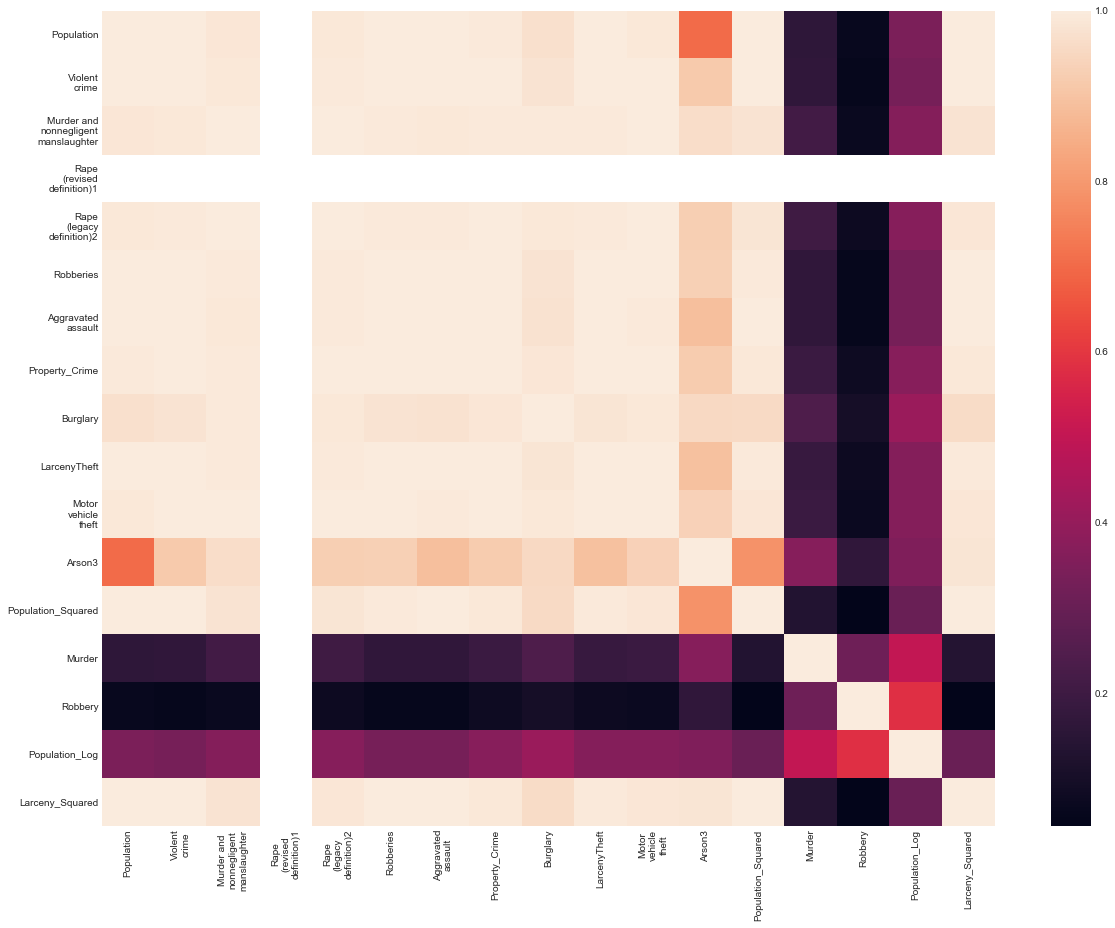

In [29]:
plt.figure(figsize=(20,15))
sns.heatmap(NY2013.corr())

Now let's try going back to the original data on murder and robbery, rather than our created categorical feature

In [30]:
#clean up name of original murder variable
NY2013.rename(columns={'Murder and\nnonnegligent\nmanslaughter': 'MurderManslaughter'}, inplace=True)

In [31]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = NY2013['Property_Crime'].values.reshape(-1, 1)
X = NY2013[['Population','Population_Squared','MurderManslaughter', 'Robberies','Population_Log', 'LarcenyTheft', 'Larceny_Squared', 'Burglary']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 4.13054033e-04 -5.47003776e-10 -1.35534561e+00  4.07151701e-01
  -1.69789053e+00  9.85277541e-01  2.53351197e-06  1.10183243e+00]]

Intercept: 
 [12.78462086]

R-squared:
0.999999030656361


Adding back the original data on Murder and Robberies increased the R-squared value.  Let's see what Stats Model reveals.

In [44]:
#model formula
linear_formula = 'Property_Crime ~ Population+Population_Squared+MurderManslaughter+Robberies+Population_Log+LarcenyTheft+Larceny_Squared+Burglary'

#fit model to data
lm = smf.ols(formula=linear_formula, data=NY2013).fit()

print('Coefficients:\n', lm.params)

Coefficients:
 Intercept             1.278462e+01
Population            4.130540e-04
Population_Squared   -5.470038e-10
MurderManslaughter   -1.355346e+00
Robberies             4.071517e-01
Population_Log       -1.697891e+00
LarcenyTheft          9.852775e-01
Larceny_Squared       2.533512e-06
Burglary              1.101832e+00
dtype: float64


In [45]:
print('P-Values:\n', lm.pvalues)

P-Values:
 Intercept              1.176910e-02
Population             7.280844e-12
Population_Squared     3.907932e-09
MurderManslaughter     7.570737e-03
Robberies              2.952508e-48
Population_Log         5.962228e-03
LarcenyTheft           0.000000e+00
Larceny_Squared        9.812990e-08
Burglary              5.557694e-266
dtype: float64


In [47]:
print('R-squared:\n', lm.rsquared)

R-squared:
 0.9999990306563609


It's looking pretty good, let's just check on the residuals

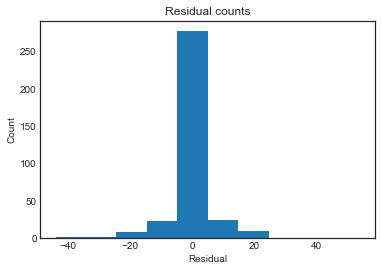

In [34]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = NY2013['Property_Crime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

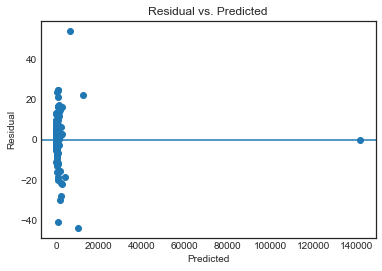

In [35]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

### Test with new data - New York 2014

In [48]:
NY2014 = pd.read_excel('/Users/marenbeckman/Desktop/Data_Science/FBI/New_York_by_City_2014.xls')
NY2014.columns

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3'],
      dtype='object')

In [49]:
#clean up target variable for NY 2014
NY2014.rename(columns={'Property\ncrime': 'Property_Crime'}, inplace=True)
NY2014 = NY2014[np.isfinite(NY2014['Property_Crime'])]

In [50]:
# Create New Features for NY 2014

NY2014['Population_Squared'] = NY2014['Population'] * NY2014['Population']

NY2014['Population_Log'] = np.log(NY2014['Population'])

NY2014.rename(columns={'Robbery': 'Robberies'}, inplace=True)

NY2014.rename(columns={'Larceny-\ntheft': 'LarcenyTheft'}, inplace=True)

NY2014['Larceny_Squared'] = NY2014['LarcenyTheft'] * NY2014['LarcenyTheft']

NY2014.rename(columns={'Murder and\nnonnegligent\nmanslaughter': 'MurderManslaughter'}, inplace=True)

In [61]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = NY2014['Property_Crime'].values.reshape(-1, 1)
X = NY2014[['Population','Population_Squared','MurderManslaughter', 'Robberies', 'Population_Log', 'LarcenyTheft', 'Larceny_Squared', 'Burglary']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 4.21582185e-04 -5.94836897e-10 -5.45485583e-01  3.00485186e-01
  -2.26720310e+00  9.81384327e-01  3.30672528e-06  1.16411950e+00]]

Intercept: 
 [16.80501492]

R-squared:
0.9999987346068253


In [62]:
#model formula
linear_formula = 'Property_Crime ~ Population+Population_Squared+MurderManslaughter+Robberies+Population_Log+LarcenyTheft+Larceny_Squared+Burglary'

#fit model to data
lm = smf.ols(formula=linear_formula, data=NY2014).fit()

print('Coefficients:\n', lm.params)

Coefficients:
 Intercept             1.680501e+01
Population            4.215822e-04
Population_Squared   -5.948369e-10
MurderManslaughter   -5.454856e-01
Robberies             3.004852e-01
Population_Log       -2.267203e+00
LarcenyTheft          9.813843e-01
Larceny_Squared       3.306725e-06
Burglary              1.164119e+00
dtype: float64


In [63]:
print('R-squared:\n', lm.rsquared)

R-squared:
 0.9999987346068252


Our model checks out with another year, how about another state?

### Test with new data - California 2013

In [54]:
CA2013 = pd.read_excel('/Users/marenbeckman/Desktop/Data_Science/FBI/california_by_city_2013.xls')
CA2013.columns

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson'],
      dtype='object')

In [55]:
#clean up target variable for NY 2014
CA2013.rename(columns={'Property\ncrime': 'Property_Crime'}, inplace=True)
CA2013 = CA2013[np.isfinite(CA2013['Property_Crime'])]

In [56]:
# Create New Features for CA 2013

CA2013['Population_Squared'] = CA2013['Population'] * CA2013['Population']

CA2013['Population_Log'] = np.log(CA2013['Population'])

CA2013.rename(columns={'Robbery': 'Robberies'}, inplace=True)

CA2013.rename(columns={'Larceny-\ntheft': 'LarcenyTheft'}, inplace=True)

CA2013['Larceny_Squared'] = CA2013['LarcenyTheft'] * CA2013['LarcenyTheft']

CA2013.rename(columns={'Murder and\nnonnegligent\nmanslaughter': 'MurderManslaughter'}, inplace=True)

In [57]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = CA2013['Property_Crime'].values.reshape(-1, 1)
X = CA2013[['Population','Population_Squared','MurderManslaughter', 'Robberies', 'Population_Log', 'LarcenyTheft', 'Larceny_Squared', 'Burglary']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 4.62595452e-03 -7.61925018e-10  7.65279655e+00  8.10835557e-01
  -7.82636916e+01  9.39786803e-01 -4.80204017e-07  1.32039859e+00]]

Intercept: 
 [660.80051569]

R-squared:
0.9987401884718545


In [58]:
#model formula
linear_formula = 'Property_Crime ~ Population+Population_Squared+MurderManslaughter+Robberies+Population_Log+LarcenyTheft+Larceny_Squared+Burglary'

#fit model to data
lm = smf.ols(formula=linear_formula, data=NY2014).fit()

print('Coefficients:\n', lm.params)

Coefficients:
 Intercept             1.680501e+01
Population            4.215822e-04
Population_Squared   -5.948369e-10
MurderManslaughter   -5.454856e-01
Robberies             3.004852e-01
Population_Log       -2.267203e+00
LarcenyTheft          9.813843e-01
Larceny_Squared       3.306725e-06
Burglary              1.164119e+00
dtype: float64


In [60]:
print('R-squared:\n', lm.rsquared)

R-squared:
 0.9999987346068252


Good accuracy here as well.